# **Libraries**

In [ ]:
import numpy as np
import pandas as pd
import time
from operator import add
import math
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from math import sqrt

# **Prepare data**

In [ ]:
df = pd.read_csv('mnist_test.csv')
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = df.drop(['label'], axis=1)
df.head()

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = df.values
X = X/255.
print(X.dtype)
X_train = X[:200]
X_valid = X[200:251]
X_test  = X[251:315]

float64


# **Activation functions**

In [ ]:
class Sigmoid():
    def __call__(self, x):
        return 1 / (1 + np.exp(-x,where=True))
    def Derivative(self, x):
        return self.__call__(x) * (1 - self.__call__(x))

# **MLP Model**

In [ ]:
class MLP:
    def __init__(self,alpha,layer_dims):                       # layer_dims = List: [n_input,...n_hidd,....n_out]
        self.alpha = alpha
        self.dims = layer_dims[1:]                             # [784,64,784] --> 64,784 --> bias sizes: (64,1),(784,1)
        self.sizes = list(zip(layer_dims, layer_dims[1:]))     # [784,64,784] --> weight sizes: (784,64),(64,784)
        self.weights_list = []
        # set initail weights and biases
        for s in self.sizes:
            self.weights_list.append(np.random.uniform(low=-0.1, high=0.1, size=s))

        self.biases_list = []
        for d in self.dims:
            self.biases_list.append(np.random.uniform(low=-0.1, high=0.1, size=(1,d)))

        self.HiddenActFunc = Sigmoid()
        self.OutActFunc = Sigmoid()

    def merge(self,list1, list2):

        merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
        return merged_list

    def feedforward(self,x, w_list, b_list):                      # row: sample index , WL: weight list , BL: bias list

        weighted_sums = []
        layers_inputs = []                                    # layer-inputs * w + b ---> weighted_sums
        layers_w_and_b = self.merge(w_list, b_list)

        for w,b in layers_w_and_b:
            layers_inputs.append(x.reshape(1,w.shape[0]))
            y_in = np.dot(x.reshape(1,w.shape[0]),w) + b
            x = self.HiddenActFunc(y_in)                      # layer_out is next layer_input
            weighted_sums.append(y_in)

        y_pred = x                                          # save lastlayer's output as prediction
        return y_pred, layers_inputs, weighted_sums

    def backpropagation(self, w_list, b_list, layers_inputs, weighted_sums, y_pred):
        y = layers_inputs[0]                     # first layer input: data(x[row]: sample)
        delta_in=[]
#         Last_w = w_list[-1]
        last_y_in = weighted_sums.pop()         # output layer act func. input
        w_list.reverse()                        # reverse weight list to move the outputlayer weight to first of the list
        b_list.reverse()                        # same for bias list
        last_w = w_list.pop()                   # pop input layer's weight becouse it's not used in BP formula
        weighted_sums.reverse()
        layers_inputs.reverse()

        delta = (y - y_pred) * self.OutActFunc.Derivative(last_y_in)          # find outp layer's delta-error

        deltas_list=[]                                                        # all delta-errors list
        deltas_list.append(delta)

        layers_in_and_w = self.merge(weighted_sums,w_list)
        for y_in, w in layers_in_and_w:
            delta_in = np.dot(delta, w.T)
            delta_H = self.alpha*delta_in * self.HiddenActFunc.Derivative(y_in)  # delta_H: hidden layers' delta-errors
            deltas_list.append(delta_H)
            delta = delta_H

        w_list.append(last_w)                                                    # return back the input-layer's weight to w-list

        layers_in_and_delta = self.merge(layers_inputs,deltas_list)
        delta_w_list = []                                                        # Dwlist: Delta-Weights' list
        delta_b_list = []
        for IN, delta in layers_in_and_delta:
            delta_w = self.alpha * np.dot(IN.T,delta)
            delta_b = self.alpha * delta

            delta_w_list.append(delta_w)
            delta_b_list.append(delta_b)

        w_list_new = []
        b_list_new = []


        for index,element in enumerate(w_list):                            # new weight list = w-list + Delta-weight list
            w_list_new.append(element+delta_w_list[index])
        for index,element in enumerate(b_list):                            # same for bias
            b_list_new.append(element+delta_b_list[index])

        w_list_new.reverse()
        b_list_new.reverse()

        w_list = w_list_new
        b_list = b_list_new

        return w_list, b_list                                                # returns updated weights and biases lists

    def epoch(self,X):
        self.y_pred_list = []                                                  # all predicted values for all train samples in 1 epoc
        for x in X:
            y_pred, layers_inputs, weighted_sums = self.feedforward(x, self.weights_list, self.biases_list)
            self.weights_list, self.biases_list = self.backpropagation(self.weights_list, self.biases_list, layers_inputs, weighted_sums, y_pred)
            self.y_pred_list.append(y_pred)

    def train(self,X_train,X_val,max_epoc,epsilon,patience):                    #self.epsilon self.valid patience
        MSE_val_list=[]
        failed_epocs_list = []
        MSE_val_diff_list = []
        # valid MSE(t) before epoc
        y_val_pred = self.predict(X_val)
        MSE_val_before = self.MSE(X_val, y_val_pred)

        for epoc in range(1,max_epoc+1):

            self.epoch(X_train)
            # train MSE
            MSE_train = self.MSE(X_train, np.vstack(np.array(self.y_pred_list)))
            # valid MSE(t+1)  after epoc
            y_val_pred_new= self.predict(X_val)
            MSE_val_after = self.MSE(X_val, y_val_pred_new)
            MSE_val_list.append(MSE_val_after)
            # val MSE diff before and after train
            MSE_val_diff = round(MSE_val_before - MSE_val_after,6)
            MSE_val_diff_list.append(MSE_val_diff)

            # print(max(MSE_val_diff_list),"ddd",MSE_val_diff)

            if  np.sign(MSE_val_diff) == -1:
              # val_loss_not_improving = True
              failed_epocs_list.append(epoc)
              #----------------------------------------early stop condition--------------------------------------
              if len(failed_epocs_list) == patience:
                print(f'Early stopping at epoch-{epoc} for {round(MSE_train,6)}')
                self.PLOT(epoc,MSE_val_list)
                break
            else:
              failed_epocs_list = []
            #-------------------------------------------epsilon condition----------------------------------------
            if MSE_train < epsilon:
                print(f'------Train MSE limit reached at epoch_{epoc} and train MSE: {round(MSE_train,6)}------')
                self.PLOT(epoc,MSE_val_list)
                break

            MSE_val_before = MSE_val_after.copy()
            print(f'------Epoch_{epoc}: train MSE = {round(MSE_train,6)} -- Validation MSE = {round(MSE_val_after,6)}------')
            # print("length: ", len(failed_epocs_list))
            #-------------------------------------------max epoch condition----------------------------------------
            if epoc==max_epoc:
              print('End of epochs!')
              self.PLOT(epoc,MSE_val_list)


    def predict(self,X):                                                           # x: X_test
        preds_list = []
        for x in X:
            (pred,_,_) = self.feedforward(x, self.weights_list, self.biases_list)   # i: each row of the x
            preds_list.append(pred)
        return np.vstack(np.array(preds_list))                                                           # predList: list of arrays --> y_pred --> should convert to an array

    def MSE(self,actual, predicted):
        actual = np.clip(actual, 1e-15, 1 - 1e-15)                                  # convert min(actual): from 0 to 10^-15, same for max
        sum_square_error = 0.0
        for i in range(len(actual)):
            sum_square_error += (actual[i] - predicted[i])**2.0
            mean_square_error = (1.0 / (2*len(actual))) * sum_square_error
        return np.mean(mean_square_error, axis=0)

    def PLOT(self,epoc, MSE_val_list):
        plt.plot(range(1, epoc+1), MSE_val_list)
        plt.xlabel('Epoch')
        plt.ylabel('MSE_validation')
        plt.show()

    def display(self, input_arr, title):
      sqrt_input_arr = sqrt(input_arr.shape[0])
      if sqrt_input_arr.is_integer():
        height_unit = int(sqrt_input_arr)
        width_unit = int(sqrt_input_arr)
      else:
        height_unit = int(sqrt_input_arr)
        width_unit = height_unit + 1

      images = ((input_arr*255.).reshape(-1, 28, 28)).astype(np.uint8)

      # Create the first subplot for the MNIST images
      fig1, axis_arr = plt.subplots(height_unit, width_unit, figsize=(4, 4))
      fig1.suptitle(f'{title}', fontsize=16)

      # Flatten the axes array for easy iteration
      axis_arr = axis_arr.flatten()

      # Plot each original image
      for i in range(len(images)):
          axis_arr[i].imshow(images[i], cmap='gray')
          axis_arr[i].axis('off')

      # Hide any unused subplots
      for i in range(len(images), len(axis_arr)):
          fig1.delaxes(axis_arr[i])

      plt.tight_layout()
      # Adjust the top to make room for the suptitle
      plt.subplots_adjust(top=0.88)
      plt.show()

In [ ]:
# ALgortithm: train --> epocs --> forwardpath --> y_in --> act func. --> y_pre -->BackProp (update) --> epoch loop

# **One Hidden layer** - 64, 128 and alpha=0.1

------Epoch_1: train MSE = 0.035676 -- Validation MSE = 0.032132------
------Epoch_2: train MSE = 0.029646 -- Validation MSE = 0.028327------
------Epoch_3: train MSE = 0.025517 -- Validation MSE = 0.025617------
------Epoch_4: train MSE = 0.02277 -- Validation MSE = 0.023586------
------Epoch_5: train MSE = 0.020652 -- Validation MSE = 0.021921------
------Epoch_6: train MSE = 0.018921 -- Validation MSE = 0.020539------
------Epoch_7: train MSE = 0.017447 -- Validation MSE = 0.019373------
------Epoch_8: train MSE = 0.016162 -- Validation MSE = 0.018388------
------Epoch_9: train MSE = 0.015046 -- Validation MSE = 0.017555------
------Epoch_10: train MSE = 0.014081 -- Validation MSE = 0.016846------
------Epoch_11: train MSE = 0.013242 -- Validation MSE = 0.016234------
------Epoch_12: train MSE = 0.012508 -- Validation MSE = 0.015703------
------Epoch_13: train MSE = 0.011858 -- Validation MSE = 0.015238------
------Epoch_14: train MSE = 0.011278 -- Validation MSE = 0.014828------
--

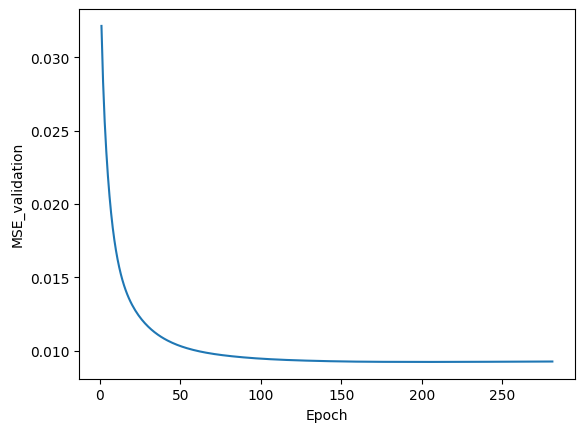

durationt:  67.59330201148987 seconds



In [ ]:
model = MLP(alpha=0.1, layer_dims=[784,64,784])                # prepare the model: define the functions

start_time = time.time()

model.train(X_train, X_valid, max_epoc=500, epsilon=0.0001, patience=10)

print('durationt: ',time.time() - start_time, 'seconds')
print()

test MSE: 0.008871717062963063


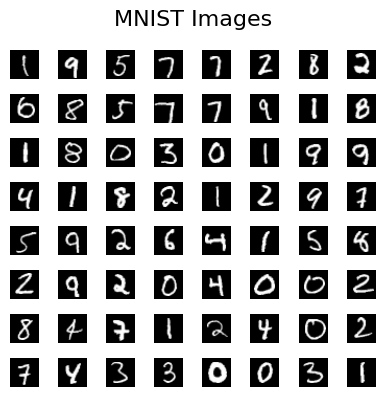

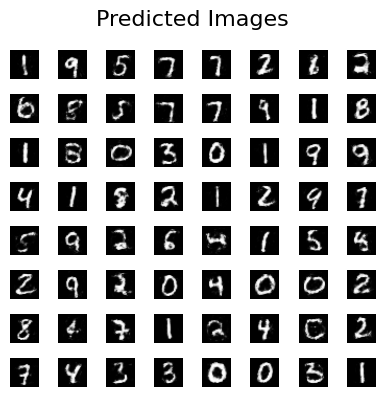

In [ ]:
y_pred = model.predict(X_test)

print("test MSE:", model.MSE(X_test, y_pred))
model.display(X_test, "MNIST Images")
model.display(y_pred, "Predicted Images")

------Epoch_1: train MSE = 0.034452 -- Validation MSE = 0.03043------
------Epoch_2: train MSE = 0.027193 -- Validation MSE = 0.025861------
------Epoch_3: train MSE = 0.022775 -- Validation MSE = 0.022991------
------Epoch_4: train MSE = 0.019928 -- Validation MSE = 0.020875------
------Epoch_5: train MSE = 0.017766 -- Validation MSE = 0.019231------
------Epoch_6: train MSE = 0.016019 -- Validation MSE = 0.017911------
------Epoch_7: train MSE = 0.014571 -- Validation MSE = 0.016831------
------Epoch_8: train MSE = 0.013364 -- Validation MSE = 0.015933------
------Epoch_9: train MSE = 0.012351 -- Validation MSE = 0.015178------
------Epoch_10: train MSE = 0.011488 -- Validation MSE = 0.014535------
------Epoch_11: train MSE = 0.010743 -- Validation MSE = 0.013982------
------Epoch_12: train MSE = 0.01009 -- Validation MSE = 0.013501------
------Epoch_13: train MSE = 0.009509 -- Validation MSE = 0.013078------
------Epoch_14: train MSE = 0.008986 -- Validation MSE = 0.012702------
---

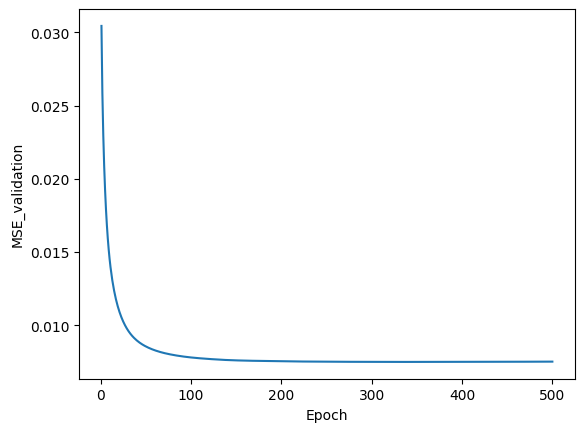

durationt:  169.0349624156952 seconds



In [ ]:
model = MLP(alpha=0.1, layer_dims=[784,128,784])                # prepare the model: define the functions

start_time = time.time()

model.train(X_train, X_valid, max_epoc=500, epsilon=0.0001, patience=10)

print('durationt: ',time.time() - start_time, 'seconds')
print()

test MSE: 0.007315791910868222


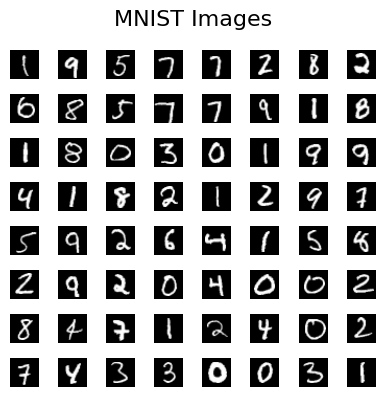

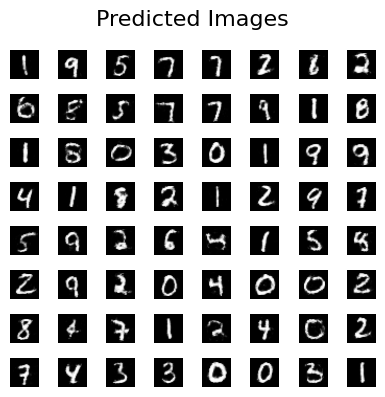

In [ ]:
y_pred = model.predict(X_test)

print("test MSE:", model.MSE(X_test, y_pred))
model.display(X_test, "MNIST Images")
model.display(y_pred, "Predicted Images")

# **Three Hidden layers** - 256,64,256 - alpha = 0.1

------Epoch_1: train MSE = 0.036626 -- Validation MSE = 0.034381------
------Epoch_2: train MSE = 0.034457 -- Validation MSE = 0.033602------
------Epoch_3: train MSE = 0.033677 -- Validation MSE = 0.03313------
------Epoch_4: train MSE = 0.033181 -- Validation MSE = 0.032839------
------Epoch_5: train MSE = 0.032861 -- Validation MSE = 0.032645------
------Epoch_6: train MSE = 0.032643 -- Validation MSE = 0.032508------
------Epoch_7: train MSE = 0.032485 -- Validation MSE = 0.032405------
------Epoch_8: train MSE = 0.032366 -- Validation MSE = 0.032325------
------Epoch_9: train MSE = 0.032271 -- Validation MSE = 0.032259------
------Epoch_10: train MSE = 0.032194 -- Validation MSE = 0.032204------
------Epoch_11: train MSE = 0.032129 -- Validation MSE = 0.032158------
------Epoch_12: train MSE = 0.032074 -- Validation MSE = 0.032118------
------Epoch_13: train MSE = 0.032025 -- Validation MSE = 0.032082------
------Epoch_14: train MSE = 0.031983 -- Validation MSE = 0.03205------
---

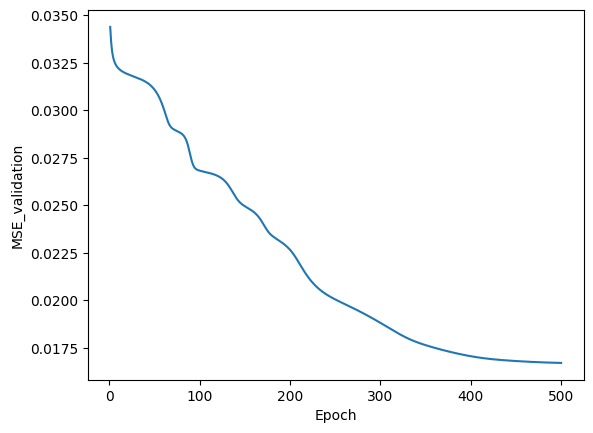

durationt:  426.4556231498718 seconds



In [ ]:
model = MLP(alpha=0.1, layer_dims=[784,256,64,256,784])                # prepare the model: define the functions

start_time = time.time()

model.train(X_train, X_valid, max_epoc=500, epsilon=0.0001, patience=10)

print('durationt: ',time.time() - start_time, 'seconds')
print()

test MSE: 0.015620544370230126


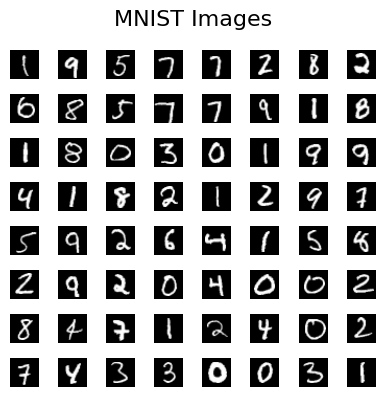

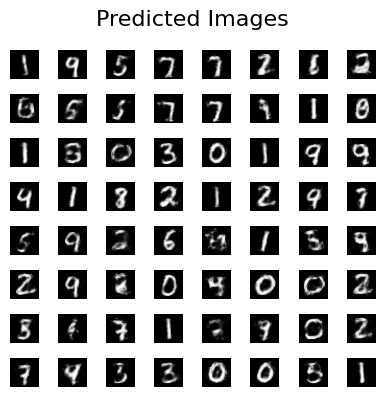

In [ ]:
y_pred = model.predict(X_test)

print("test MSE:", model.MSE(X_test, y_pred))
model.display(X_test, "MNIST Images")
model.display(y_pred, "Predicted Images")

# **Three Hidden layers** - 256,64,256 - alpha = 0.01

------Epoch_1: train MSE = 0.040694 -- Validation MSE = 0.033091------
------Epoch_2: train MSE = 0.032474 -- Validation MSE = 0.03236------
------Epoch_3: train MSE = 0.032077 -- Validation MSE = 0.032148------
------Epoch_4: train MSE = 0.03193 -- Validation MSE = 0.032049------
------Epoch_5: train MSE = 0.031855 -- Validation MSE = 0.031993------
------Epoch_6: train MSE = 0.031809 -- Validation MSE = 0.031957------
------Epoch_7: train MSE = 0.031778 -- Validation MSE = 0.031932------
------Epoch_8: train MSE = 0.031756 -- Validation MSE = 0.031913------
------Epoch_9: train MSE = 0.03174 -- Validation MSE = 0.031899------
------Epoch_10: train MSE = 0.031727 -- Validation MSE = 0.031888------
------Epoch_11: train MSE = 0.031716 -- Validation MSE = 0.031879------
------Epoch_12: train MSE = 0.031708 -- Validation MSE = 0.031871------
------Epoch_13: train MSE = 0.031701 -- Validation MSE = 0.031865------
------Epoch_14: train MSE = 0.031695 -- Validation MSE = 0.03186------
-----

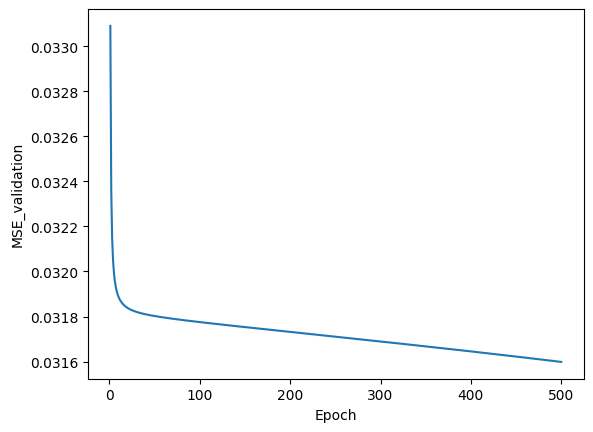

durationt:  409.8858940601349 seconds



In [ ]:
model = MLP(alpha=0.01, layer_dims=[784,256,64,256,784])                # prepare the model: define the functions

start_time = time.time()

model.train(X_train, X_valid, max_epoc=500, epsilon=0.0001, patience=10)

print('durationt: ',time.time() - start_time, 'seconds')
print()

test MSE: 0.03217513108467787


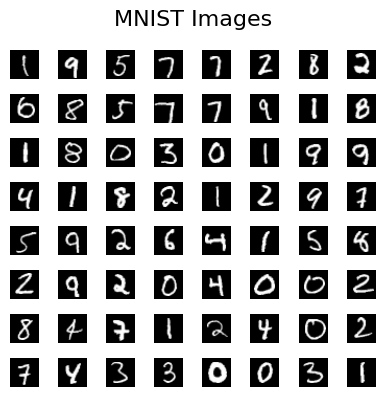

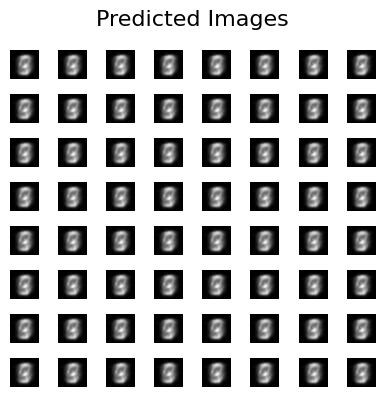

In [ ]:
y_pred = model.predict(X_test)

print("test MSE:", model.MSE(X_test, y_pred))
model.display(X_test, "MNIST Images")
model.display(y_pred, "Predicted Images")

# **Five Hidden layers** - 256,128,64,128,256 - alpha = 0.1

------Epoch_1: train MSE = 0.036533 -- Validation MSE = 0.034097------
------Epoch_2: train MSE = 0.034034 -- Validation MSE = 0.033281------
------Epoch_3: train MSE = 0.033291 -- Validation MSE = 0.032896------
------Epoch_4: train MSE = 0.0329 -- Validation MSE = 0.032674------
------Epoch_5: train MSE = 0.032661 -- Validation MSE = 0.032529------
------Epoch_6: train MSE = 0.032498 -- Validation MSE = 0.032424------
------Epoch_7: train MSE = 0.032379 -- Validation MSE = 0.032345------
------Epoch_8: train MSE = 0.032287 -- Validation MSE = 0.032283------
------Epoch_9: train MSE = 0.032214 -- Validation MSE = 0.032233------
------Epoch_10: train MSE = 0.032154 -- Validation MSE = 0.032191------
------Epoch_11: train MSE = 0.032104 -- Validation MSE = 0.032155------
------Epoch_12: train MSE = 0.03206 -- Validation MSE = 0.032124------
------Epoch_13: train MSE = 0.032023 -- Validation MSE = 0.032097------
------Epoch_14: train MSE = 0.03199 -- Validation MSE = 0.032073------
-----

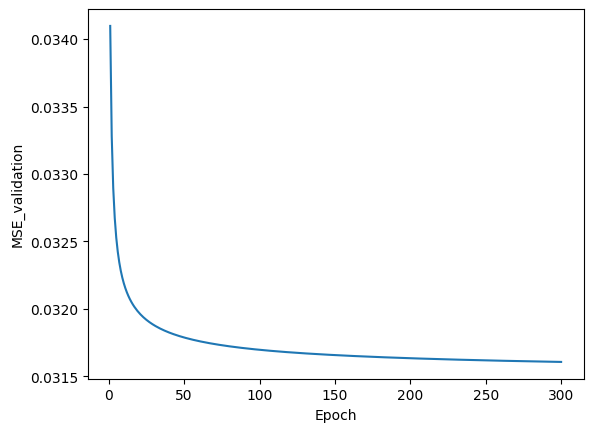

durationt:  236.21846318244934 seconds



In [ ]:
model = MLP(alpha=0.1, layer_dims=[784,256,128,64,128,256,784])                # prepare the model: define the functions

start_time = time.time()

model.train(X_train, X_valid, max_epoc=300, epsilon=0.0001, patience=10)

print('durationt: ',time.time() - start_time, 'seconds')
print()

test MSE: 0.03231080715731816


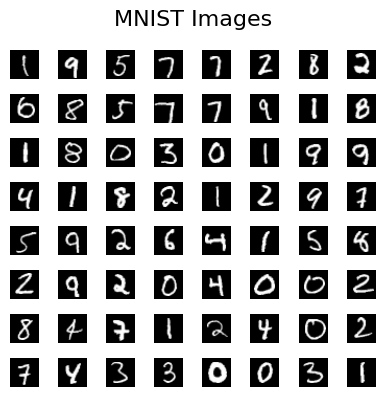

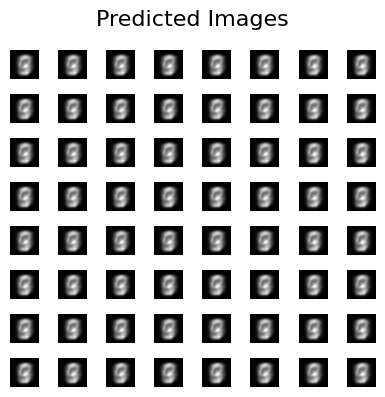

In [ ]:
y_pred = model.predict(X_test)

print("test MSE:", model.MSE(X_test, y_pred))
model.display(X_test, "MNIST Images")
model.display(y_pred, "Predicted Images")

# **Five Hidden layers** - 256,128,64,128,256 - alpha = 0.01

------Epoch_1: train MSE = 0.040647 -- Validation MSE = 0.033037------
------Epoch_2: train MSE = 0.032451 -- Validation MSE = 0.032346------
------Epoch_3: train MSE = 0.032075 -- Validation MSE = 0.032146------
------Epoch_4: train MSE = 0.031937 -- Validation MSE = 0.032053------
------Epoch_5: train MSE = 0.031866 -- Validation MSE = 0.032------
------Epoch_6: train MSE = 0.031823 -- Validation MSE = 0.031966------
------Epoch_7: train MSE = 0.031794 -- Validation MSE = 0.031943------
------Epoch_8: train MSE = 0.031774 -- Validation MSE = 0.031926------
------Epoch_9: train MSE = 0.031759 -- Validation MSE = 0.031913------
------Epoch_10: train MSE = 0.031747 -- Validation MSE = 0.031902------
------Epoch_11: train MSE = 0.031737 -- Validation MSE = 0.031894------
------Epoch_12: train MSE = 0.03173 -- Validation MSE = 0.031887------
------Epoch_13: train MSE = 0.031723 -- Validation MSE = 0.031881------
------Epoch_14: train MSE = 0.031718 -- Validation MSE = 0.031876------
-----

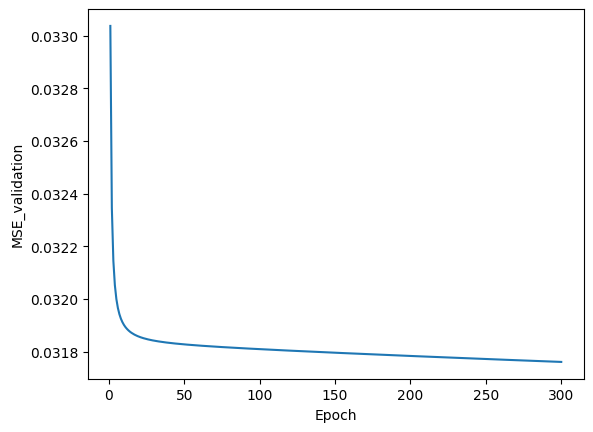

durationt:  239.9443702697754 seconds



In [ ]:
model = MLP(alpha=0.01, layer_dims=[784,256,128,64,128,256,784])                # prepare the model: define the functions

start_time = time.time()

model.train(X_train, X_valid, max_epoc=300, epsilon=0.0001, patience=10)

print('durationt: ',time.time() - start_time, 'seconds')
print()

test MSE: 0.03233652800980813


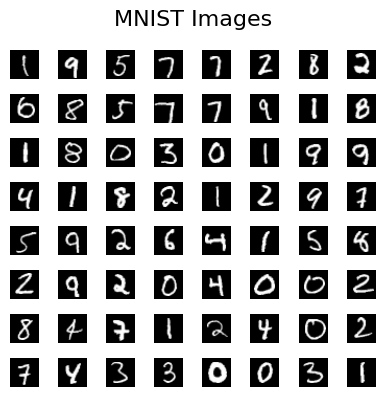

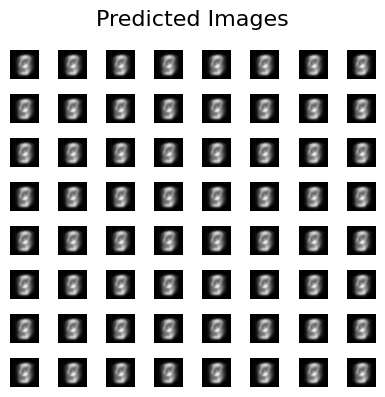

In [ ]:
y_pred = model.predict(X_test)

print("test MSE:", model.MSE(X_test, y_pred))
model.display(X_test, "MNIST Images")
model.display(y_pred, "Predicted Images")